<a href="https://colab.research.google.com/github/cuducquang/Deep-Learning/blob/main/vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 - Setup Frameworks and Libraries

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 12.3 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras_tuner as kt
import tensorflow as tf

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, Activation,
    GlobalAveragePooling2D, GlobalMaxPooling2D,
    Concatenate, Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

## 2 - EDA

In [3]:
data = np.load('dataset_dev_3000.npz')
X = data['X']   # Input images
y = data['y']   # Multi-target labels

# 2. Decompose Targets for Analysis
# y[:, 0]: Target A (Classification 0-9)
# y[:, 1]: Target B (Classification 0-31)
# y[:, 2]: Target C (Regression 0-1)
y_target_A = y[:, 0].astype(int)
y_target_B = y[:, 1].astype(int)
y_target_C = y[:, 2]

print("Data Loaded Successfully")
print(f"X Shape: {X.shape} | Type: {X.dtype}")
print(f"y Shape: {y.shape} | Type: {y.dtype}")
print("-" * 30)
print(f"Target A (Class 10): Unique values: {np.unique(y_target_A)}")
print(f"Target B (Class 32): Unique values count: {len(np.unique(y_target_B))}")
print(f"Target C (Regress):  Range [{y_target_C.min():.4f}, {y_target_C.max():.4f}]")

Data Loaded Successfully
X Shape: (3000, 32, 32) | Type: float32
y Shape: (3000, 3) | Type: float32
------------------------------
Target A (Class 10): Unique values: [0 1 2 3 4 5 6 7 8 9]
Target B (Class 32): Unique values count: 32
Target C (Regress):  Range [0.0003, 0.9996]


In [4]:
# Check Pixel Intensity Statistics
print(" Pixel Value Statistics:")
print(f"Min : {X.min()}")
print(f"Max : {X.max()}")
print(f"Mean: {X.mean():.2f}")
print(f"Std : {X.std():.2f}")

# Check for Channel Dimension
if X.ndim == 3:
    print("Insight: Images are Rank-3 (N, H, W). Need to expand dims to (N, H, W, 1) for CNN.")
else:
    print("Images already have channel dimension.")

 Pixel Value Statistics:
Min : 5.5413776863133535e-05
Max : 6.8485941886901855
Mean: 0.81
Std : 0.74
Insight: Images are Rank-3 (N, H, W). Need to expand dims to (N, H, W, 1) for CNN.


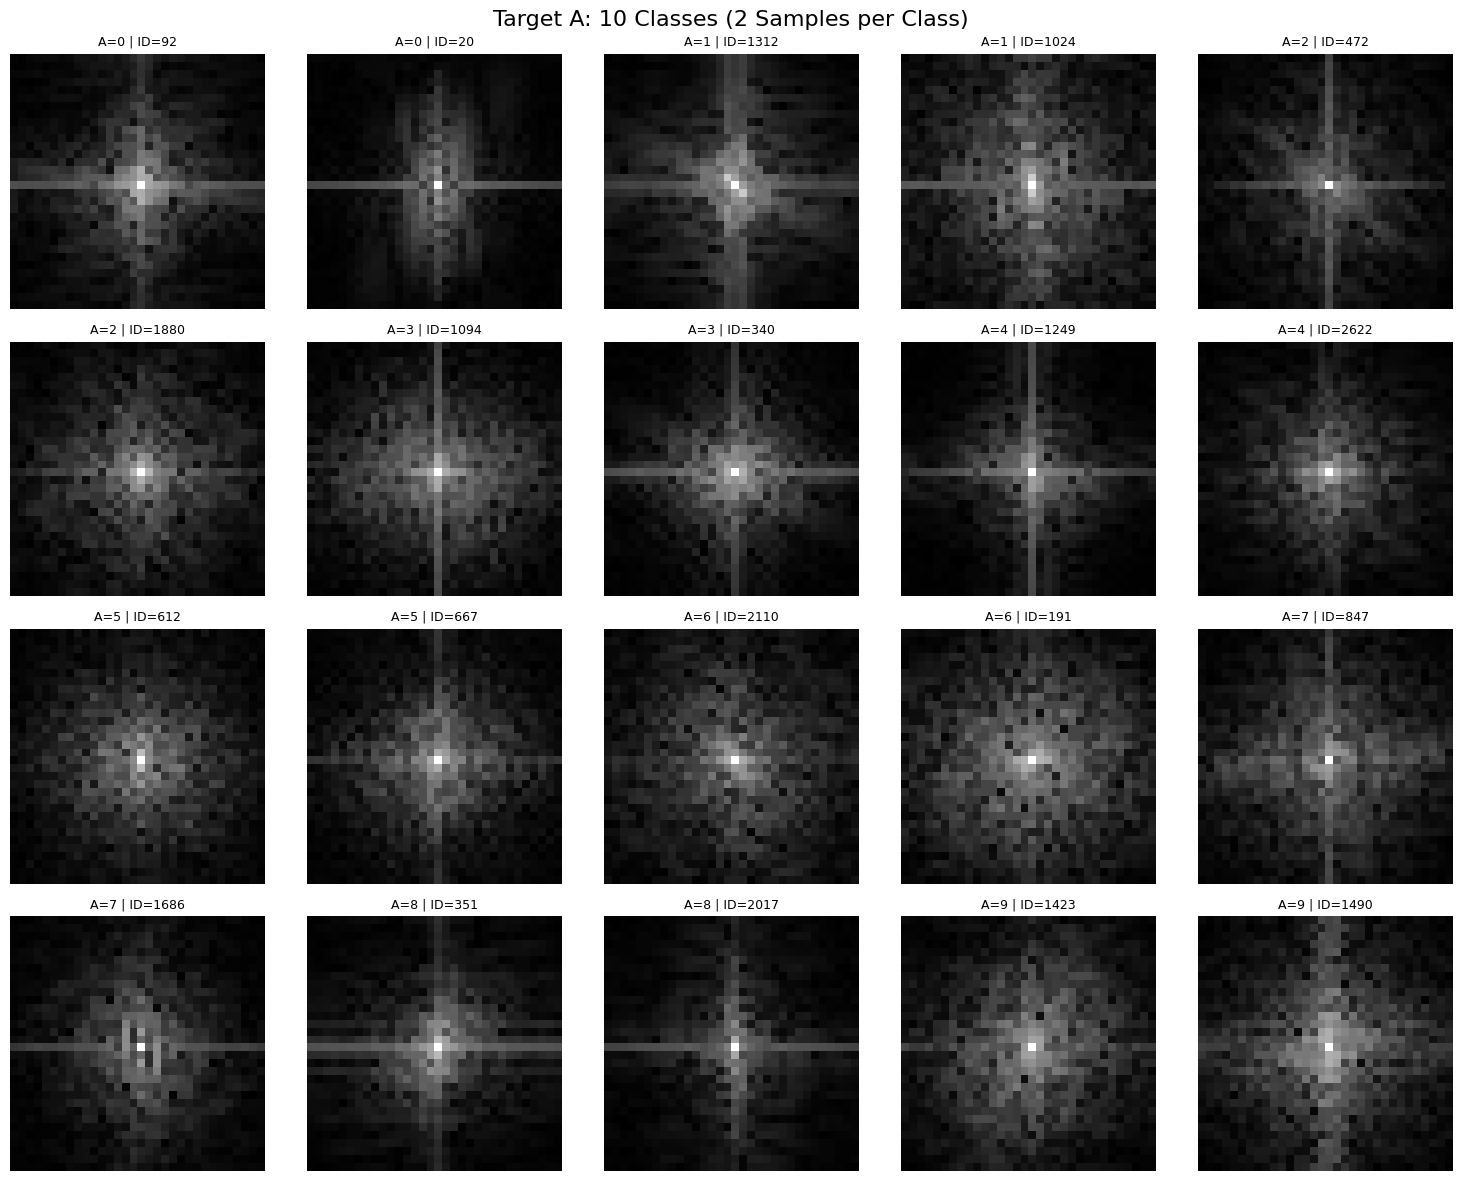

In [5]:
# Visualize random samples with their 3 labels
# -------- FIGURE 1: Target A --------
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

plot_idx = 0
for cls in range(10):
    cls_indices = np.where(y_target_A == cls)[0]
    chosen = np.random.choice(cls_indices, 2, replace=False)

    for idx in chosen:
        ax = axes[plot_idx]
        ax.imshow(X[idx], cmap='gray')
        ax.set_title(f"A={cls} | ID={idx}", fontsize=9)
        ax.axis('off')
        plot_idx += 1

fig.suptitle("Target A: 10 Classes (2 Samples per Class)", fontsize=16)
plt.tight_layout()
plt.show()

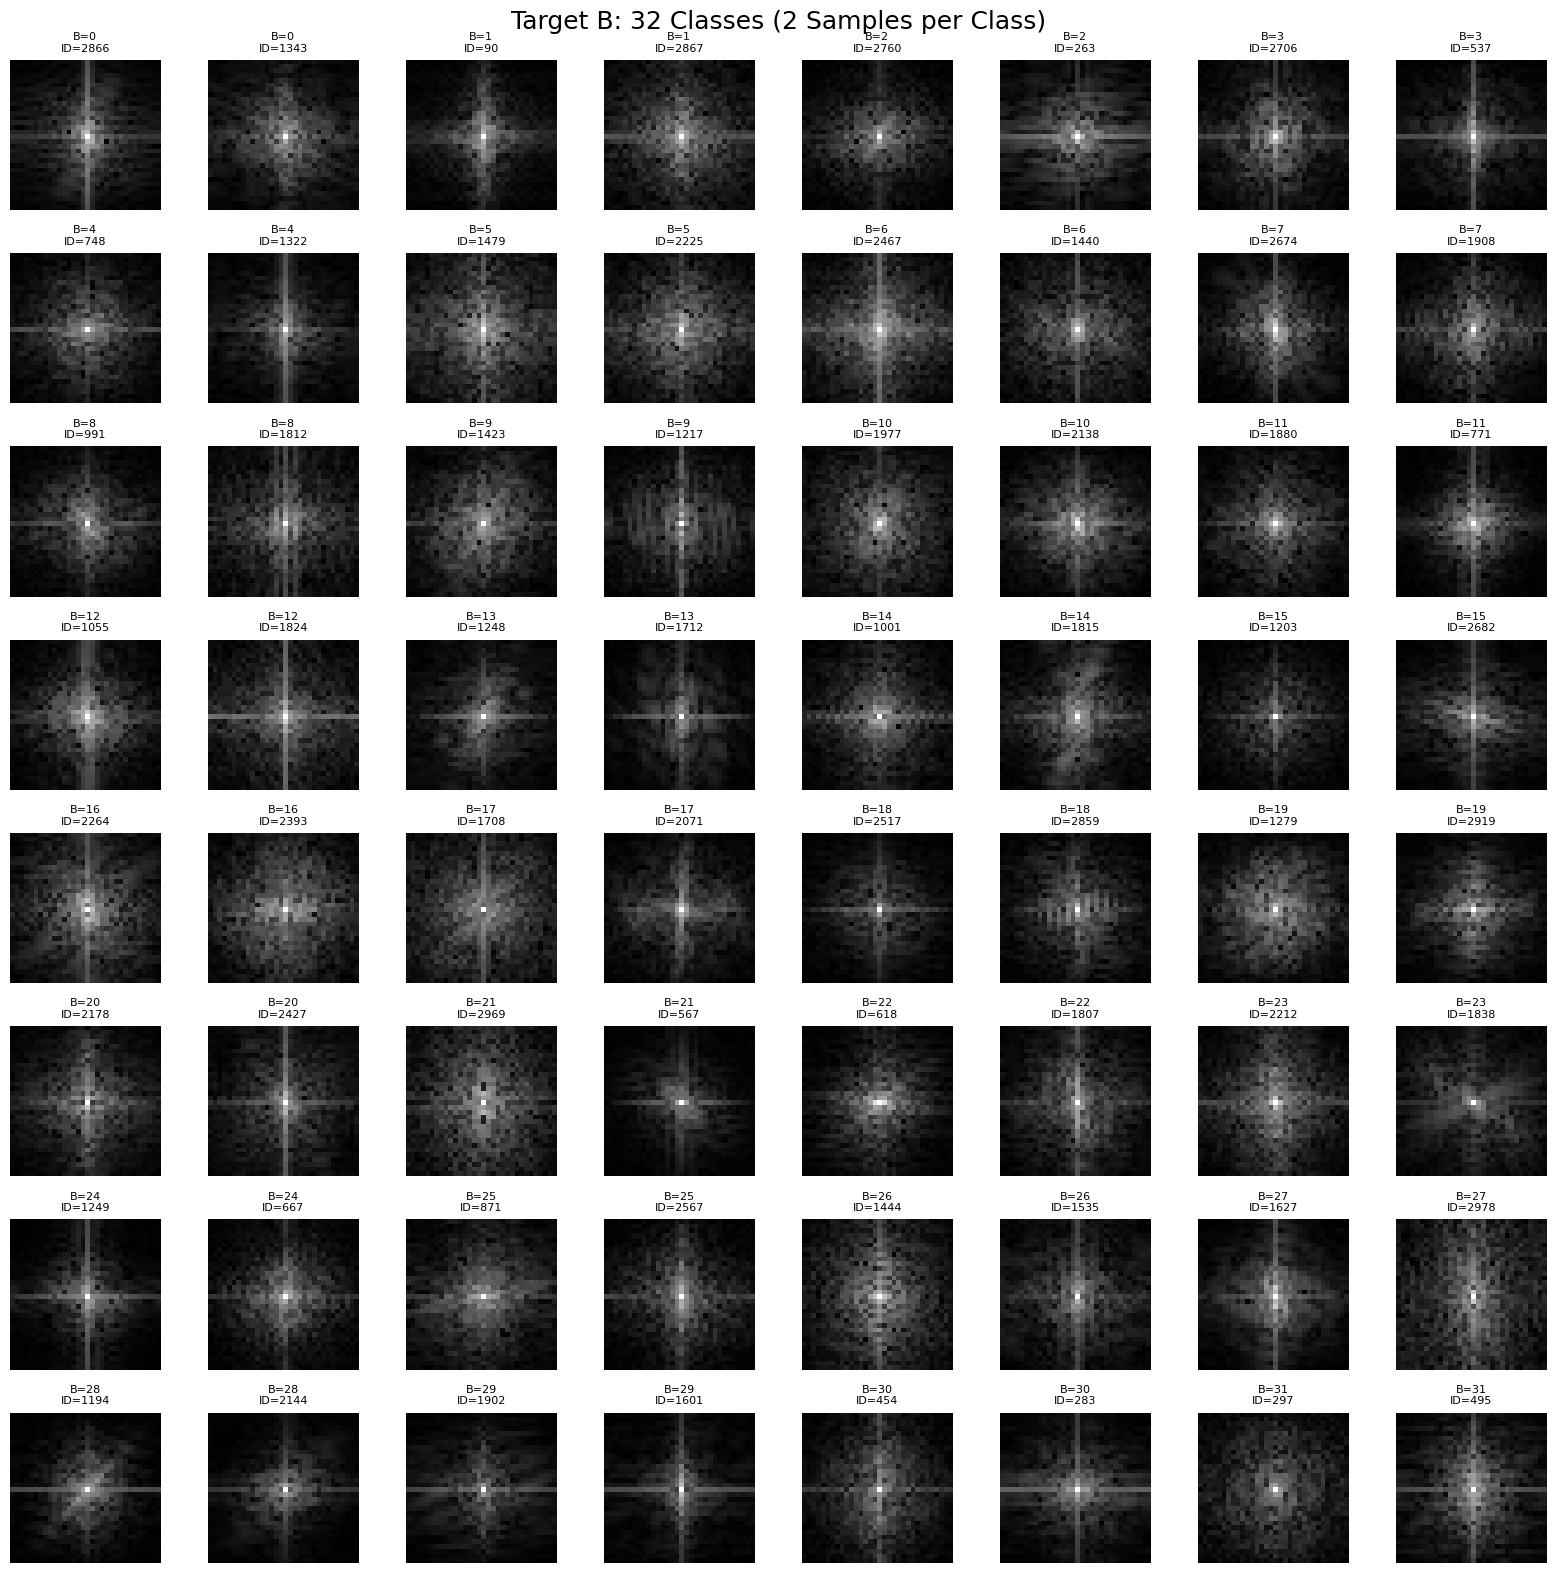

In [6]:
# -------- FIGURE 2: Target B --------
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.flatten()

plot_idx = 0
for cls in range(32):
    cls_indices = np.where(y_target_B == cls)[0]
    chosen = np.random.choice(cls_indices, 2, replace=False)

    for idx in chosen:
        ax = axes[plot_idx]
        ax.imshow(X[idx], cmap='gray')
        ax.set_title(f"B={cls}\nID={idx}", fontsize=8)
        ax.axis('off')
        plot_idx += 1

fig.suptitle("Target B: 32 Classes (2 Samples per Class)", fontsize=18)
plt.tight_layout()
plt.show()

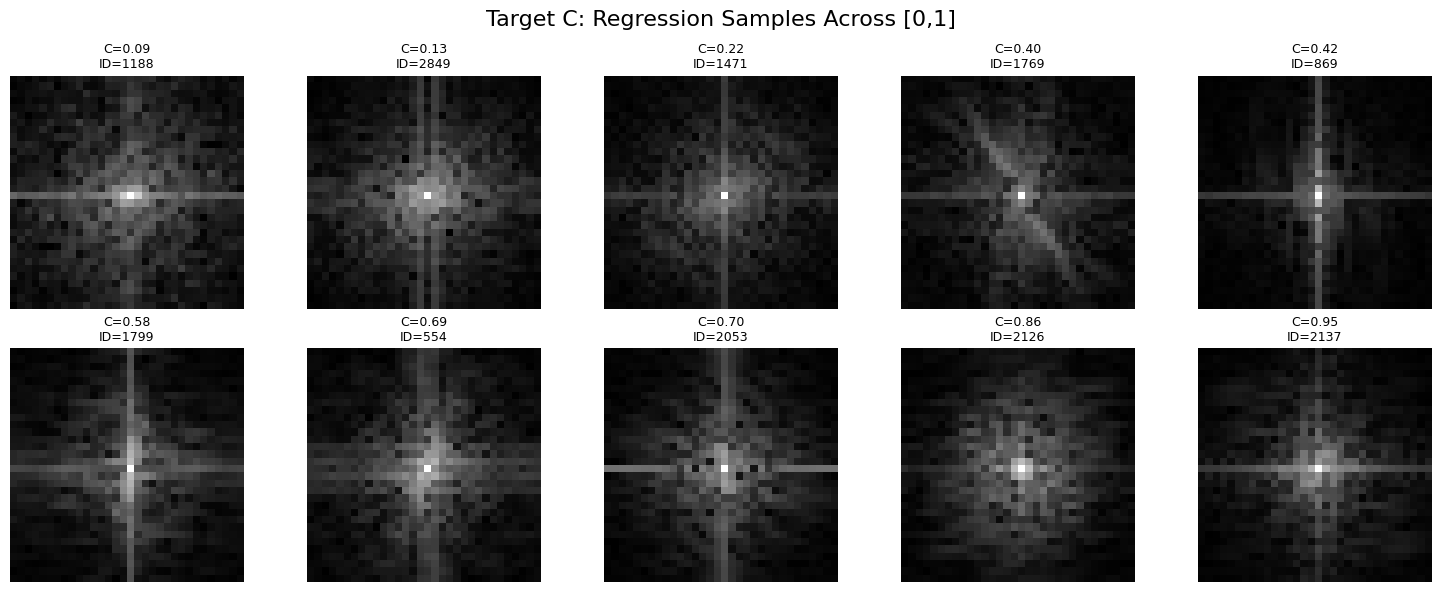

In [7]:
# -------- FIGURE 3: Target C --------
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

bins = np.linspace(0, 1, 11)

selected_indices = []
for i in range(10):
    bin_indices = np.where(
        (y_target_C >= bins[i]) & (y_target_C < bins[i+1])
    )[0]
    if len(bin_indices) > 0:
        selected_indices.append(np.random.choice(bin_indices))

for ax, idx in zip(axes, selected_indices):
    ax.imshow(X[idx], cmap='gray')
    ax.set_title(f"C={y_target_C[idx]:.2f}\nID={idx}", fontsize=9)
    ax.axis('off')

fig.suptitle("Target C: Regression Samples Across [0,1]", fontsize=16)
plt.tight_layout()
plt.show()

Target A Balance Check: {np.int64(0): np.int64(290), np.int64(1): np.int64(304), np.int64(2): np.int64(311), np.int64(3): np.int64(305), np.int64(4): np.int64(306), np.int64(5): np.int64(294), np.int64(6): np.int64(290), np.int64(7): np.int64(291), np.int64(8): np.int64(310), np.int64(9): np.int64(299)}


/tmp/ipython-input-1890465473.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_target_A, palette='viridis')


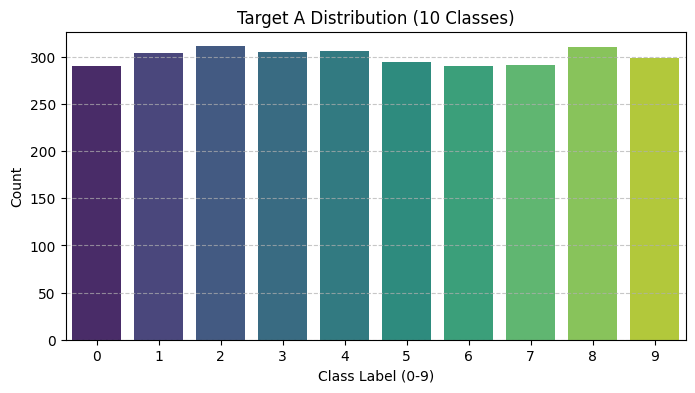

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(x=y_target_A, palette='viridis')
plt.title("Target A Distribution (10 Classes)")
plt.xlabel("Class Label (0-9)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Check exact counts
unique, counts = np.unique(y_target_A, return_counts=True)
print("Target A Balance Check:", dict(zip(unique, counts)))
plt.show()

/tmp/ipython-input-1059615394.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_target_B, palette='magma')


Target B - Min samples per class: 75
Target B - Max samples per class: 113


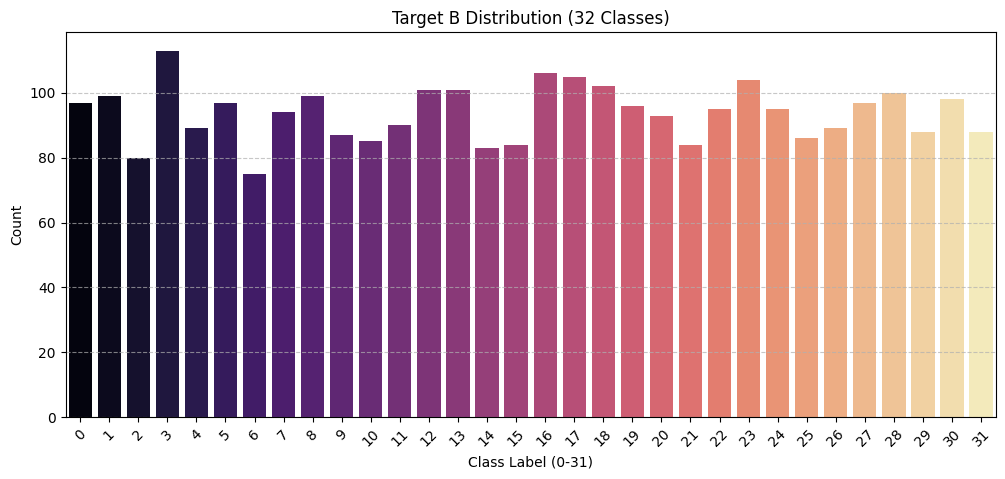

In [9]:
plt.figure(figsize=(12, 5))
sns.countplot(x=y_target_B, palette='magma')
plt.title("Target B Distribution (32 Classes)")
plt.xlabel("Class Label (0-31)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Statistics for Target B
unique_b, counts_b = np.unique(y_target_B, return_counts=True)
print(f"Target B - Min samples per class: {counts_b.min()}")
print(f"Target B - Max samples per class: {counts_b.max()}")
plt.show()

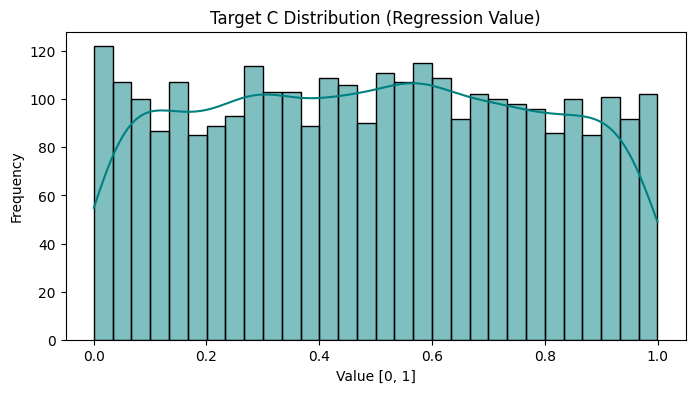

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(y_target_C, kde=True, bins=30, color='teal')
plt.title("Target C Distribution (Regression Value)")
plt.xlabel("Value [0, 1]")
plt.ylabel("Frequency")
plt.show()

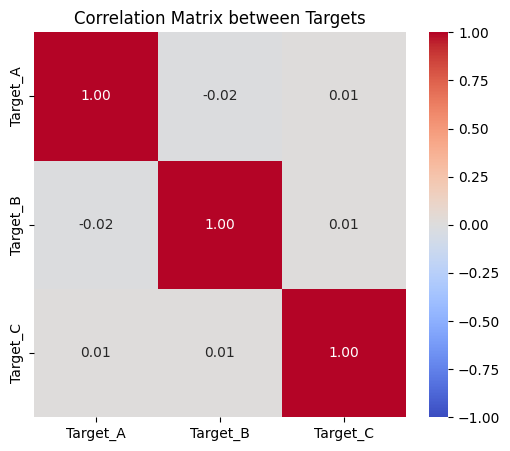

In [11]:
# Create a DataFrame for correlation checking
df_targets = pd.DataFrame({
    'Target_A': y_target_A,
    'Target_B': y_target_B,
    'Target_C': y_target_C
})

# Compute Correlation Matrix
corr_matrix = df_targets.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix between Targets")
plt.show()

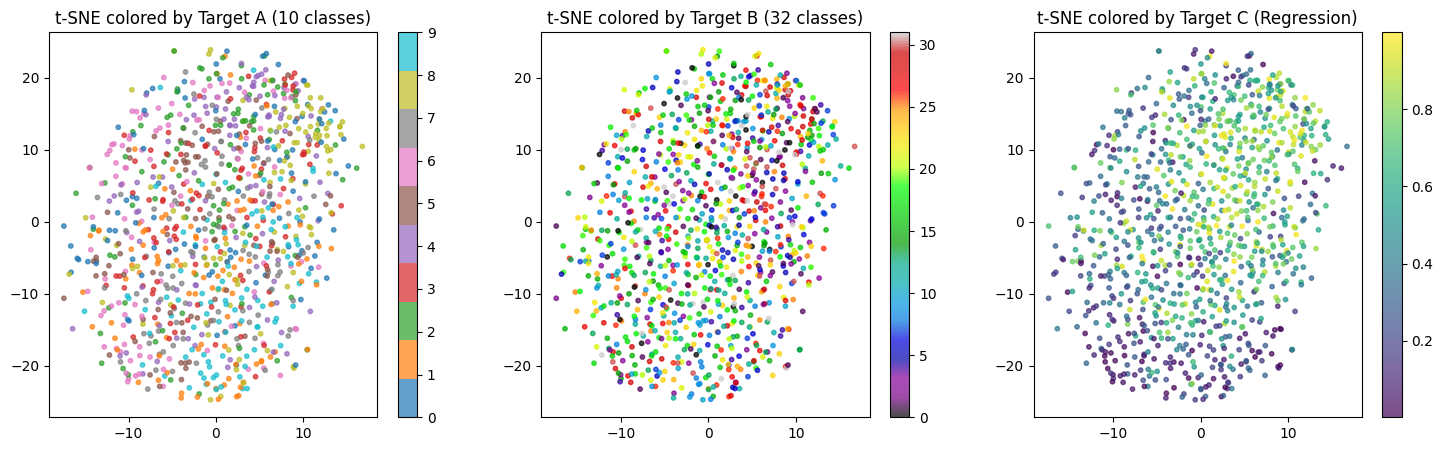

In [12]:
# Subsample for speed (1000 samples)
idx_subset = np.random.choice(len(X), 1000, replace=False)
X_tsne_input = X[idx_subset].reshape(1000, -1)
y_tsne_A = y_target_A[idx_subset]
y_tsne_B = y_target_B[idx_subset]
y_tsne_C = y_target_C[idx_subset]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_tsne_input)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot colored by Target A
scatter1 = axes[0].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_A, cmap='tab10', s=10, alpha=0.7)
axes[0].set_title("t-SNE colored by Target A (10 classes)")
plt.colorbar(scatter1, ax=axes[0])

# Plot colored by Target B
scatter2 = axes[1].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_B, cmap='nipy_spectral', s=10, alpha=0.7)
axes[1].set_title("t-SNE colored by Target B (32 classes)")
plt.colorbar(scatter2, ax=axes[1])

# Plot colored by Target C
scatter3 = axes[2].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_C, cmap='viridis', s=10, alpha=0.7)
axes[2].set_title("t-SNE colored by Target C (Regression)")
plt.colorbar(scatter3, ax=axes[2])

plt.show()

## 3 - Data Preprocessing

In [13]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# -------------------------------
# IMAGE PREPROCESSING FUNCTIONS
# -------------------------------

def log_scale(img):
    return np.log1p(img)

def remove_dc_center(img, radius=3):
    h, w = img.shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    mask = (X - cx) ** 2 + (Y - cy) ** 2 <= radius ** 2
    img = img.copy()
    img[mask] = np.median(img)
    return img

def gaussian_denoise(img):
    return cv2.GaussianBlur(img, (3, 3), 0)

def clahe_enhance(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = (img * 255).astype(np.uint8)
    img = clahe.apply(img)
    return img.astype(np.float32) / 255.0

# -------------------------------
# APPLY PIPELINE TO WHOLE DATASET
# -------------------------------

def preprocess_image(img):
    # 1) normalize
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # 2) log scale for frequency-like data
    img = log_scale(img)

    # 3) remove strong DC spike in center
    img = remove_dc_center(img)

    # 4) light denoising
    img = gaussian_denoise(img)

    # 5) contrast enhancement
    img = clahe_enhance(img)

    return img


# Apply to X (shape: N, 32, 32)
X_processed = np.array([preprocess_image(x) for x in X])

# Add channel dimension -> (N, 32, 32, 1)
X_processed = np.expand_dims(X_processed, axis=-1)


# -------------------------------
# TARGETS (unchanged logically)
# -------------------------------

y_A_raw = y[:, 0].astype(int)   # 0–9
y_B_raw = y[:, 1].astype(int)   # 0–31
y_C_raw = y[:, 2].astype(float) # regression


# -------------------------------
# TRAIN / VAL / TEST SPLIT
# -------------------------------

X_train, X_temp, yA_train, yA_temp, yB_train, yB_temp, yC_train, yC_temp = train_test_split(
    X_processed, y_A_raw, y_B_raw, y_C_raw,
    test_size=0.3, random_state=42, stratify=y_B_raw
)

X_val, X_test, yA_val, yA_test, yB_val, yB_test, yC_val, yC_test = train_test_split(
    X_temp, yA_temp, yB_temp, yC_temp,
    test_size=0.5, random_state=42, stratify=yB_temp
)

# reshape regression output
yC_train_reg = yC_train.reshape(-1, 1)
yC_val_reg   = yC_val.reshape(-1, 1)
yC_test_reg  = yC_test.reshape(-1, 1)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (2100, 32, 32, 1)
Val: (450, 32, 32, 1)
Test: (450, 32, 32, 1)


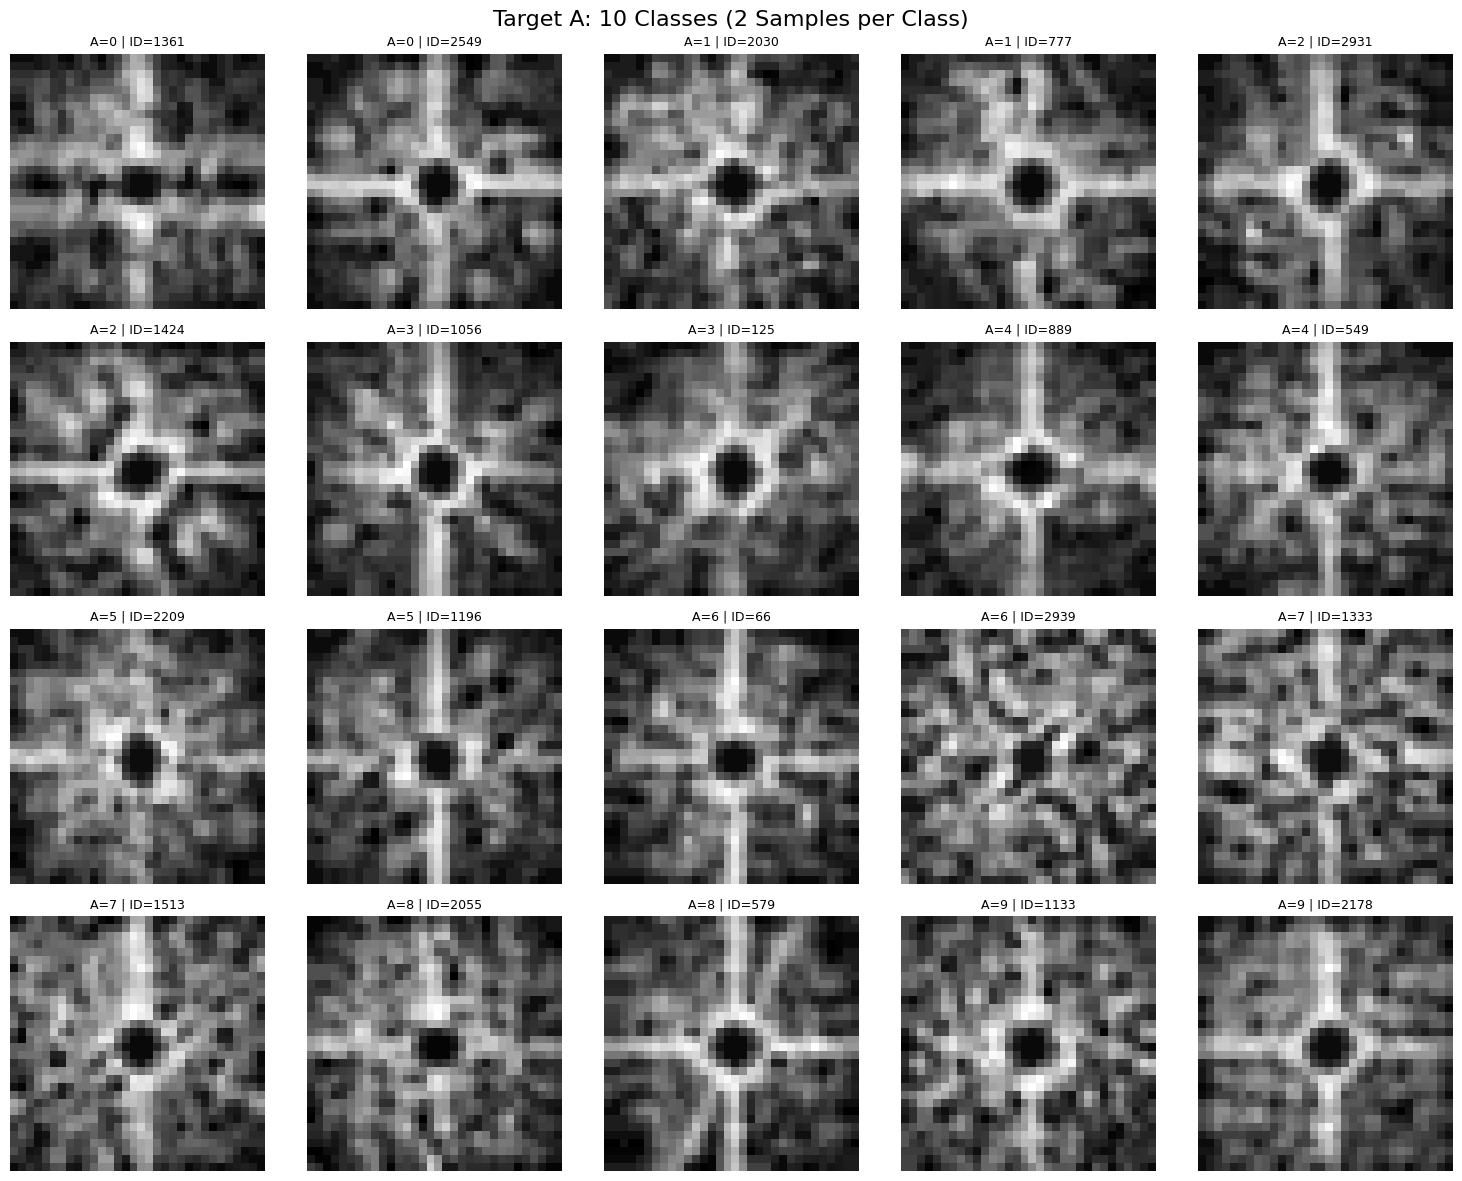

In [14]:
# Visualize random samples with their 3 labels
# -------- FIGURE 1: Target A --------
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

plot_idx = 0
for cls in range(10):
    cls_indices = np.where(y_target_A == cls)[0]
    chosen = np.random.choice(cls_indices, 2, replace=False)

    for idx in chosen:
        ax = axes[plot_idx]
        ax.imshow(X_processed[idx], cmap='gray')
        ax.set_title(f"A={cls} | ID={idx}", fontsize=9)
        ax.axis('off')
        plot_idx += 1

fig.suptitle("Target A: 10 Classes (2 Samples per Class)", fontsize=16)
plt.tight_layout()
plt.show()

In [183]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class MultiTaskDataset(Dataset):
    def __init__(self, X, yA, yB, yC):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N,32,32,1)
        self.yA = torch.tensor(yA, dtype=torch.long)
        self.yB = torch.tensor(yB, dtype=torch.long)
        self.yC = torch.tensor(yC, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].permute(2, 0, 1)  # (1,32,32)

        # Resize to 224x224
        x = F.interpolate(
            x.unsqueeze(0),
            size=(224, 224),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        return (
            x,
            torch.tensor(self.yA[idx], dtype=torch.long),
            torch.tensor(self.yB[idx], dtype=torch.long),
            torch.tensor(self.yC[idx], dtype=torch.float32)
        )


In [177]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomRotation(8),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),
    transforms.Resize((224, 224)),  # ViT requires fixed size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [178]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [179]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [184]:
from torch.utils.data import DataLoader


train_loader = DataLoader(
    MultiTaskDataset(X_train, yA_train, yB_train, yC_train_reg),
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    MultiTaskDataset(X_val, yA_val, yB_val, yC_val_reg),
    batch_size=32,
    shuffle=False
)

test_loader = DataLoader(
    MultiTaskDataset(X_test, yA_test, yB_test, yC_test_reg),
    batch_size=32,
    shuffle=False
)


## 4 - Model Architecture

In [20]:
!pip install timm

In [262]:
import timm
import torch.nn as nn

vit = timm.create_model(
    'vit_tiny_patch16_224',
    pretrained=True
)


In [263]:
vit.patch_embed.proj = nn.Conv2d(
    1, vit.embed_dim,
    kernel_size=vit.patch_embed.proj.kernel_size,
    stride=vit.patch_embed.proj.stride
)

In [264]:
embed_dim = vit.head.in_features
vit.head = nn.Identity()  # remove original classifier

class MultiTaskHead(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.headA = nn.Linear(embed_dim, 10)
        self.headB = nn.Linear(embed_dim, 32)
        self.headC = nn.Linear(embed_dim, 1)

    def forward(self, x):
        cls_token = x[:, 0, :]  # take CLS token

        return (
            self.headA(cls_token),
            self.headB(cls_token),
            self.headC(cls_token)
        )

multitask_head = MultiTaskHead(embed_dim)

In [265]:
class ViTMultiTask(nn.Module):
    def __init__(self, vit, head):
        super().__init__()
        self.vit = vit
        self.head = head

    def forward(self, x):
        x = self.vit.forward_features(x)
        return self.head(x)

model = ViTMultiTask(vit, multitask_head)

In [266]:
for param in model.vit.parameters():
    param.requires_grad = False


In [267]:
lossA = nn.CrossEntropyLoss()
lossB = nn.CrossEntropyLoss()
lossC = nn.SmoothL1Loss()  # Huber equivalent

def compute_loss(preds, targets):
    pA, pB, pC = preds
    yA, yB, yC = targets

    return (
        lossA(pA, yA) +
        2.0 * lossB(pB, yB) +
        0.3 * lossC(pC.squeeze(), yC)
    )


In [268]:
def train_one_epoch(model, loader, optimizer, criterions, device):
    model.train()

    total_loss = 0.0
    total_lossA = 0.0
    total_lossB = 0.0
    total_lossC = 0.0
    correctA = 0
    correctB = 0
    total_maeC = 0.0
    total = 0

    for x, yA, yB, yC in loader:
        x, yA, yB, yC = x.to(device), yA.to(device), yB.to(device), yC.to(device)

        optimizer.zero_grad()
        outA, outB, outC = model(x)

        lossA = criterions['A'](outA, yA)
        lossB = criterions['B'](outB, yB)
        lossC = criterions['C'](outC.squeeze(), yC.squeeze())

        loss = lossA + lossB + lossC
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_lossA += lossA.item()
        total_lossB += lossB.item()
        total_lossC += lossC.item()

        correctA += (outA.argmax(dim=1) == yA).sum().item()
        correctB += (outB.argmax(dim=1) == yB).sum().item()
        total += yA.size(0)

        # MAE for Task C
        total_maeC += torch.abs(outC.squeeze() - yC.squeeze()).sum().item()

    avg_loss = total_loss / len(loader)
    avg_lossA = total_lossA / len(loader)
    avg_lossB = total_lossB / len(loader)
    avg_lossC = total_lossC / len(loader)
    accA = correctA / total
    accB = correctB / total
    maeC = total_maeC / total

    return avg_lossA, avg_lossB, avg_lossC, accA, accB, maeC


In [274]:
@torch.no_grad()
def validate(model, dataloader, criterions, device,
             loss_weights={'A': 1.0, 'B': 2.0, 'C': 0.3}):

    model.eval()
    total_loss = 0.0
    total_lossA = 0.0
    total_lossB = 0.0
    total_lossC = 0.0
    correct_A = 0
    correct_B = 0
    total_maeC = 0.0
    total = 0

    for images, yA, yB, yC in dataloader:
        images = images.to(device)
        yA = yA.to(device)
        yB = yB.to(device)
        yC = yC.to(device)

        outA, outB, outC = model(images)

        loss_A = criterions['A'](outA, yA)
        loss_B = criterions['B'](outB, yB)
        loss_C = criterions['C'](outC.squeeze(), yC.squeeze())

        loss = (
            loss_weights['A'] * loss_A +
            loss_weights['B'] * loss_B +
            loss_weights['C'] * loss_C
        )

        total_loss += loss.item()
        total_lossA += loss_A.item()
        total_lossB += loss_B.item()
        total_lossC += loss_C.item()

        pred_A = outA.argmax(dim=1)
        pred_B = outB.argmax(dim=1)
        pred_C = outC.squeeze()

        correct_A += (pred_A == yA).sum().item()
        correct_B += (pred_B == yB).sum().item()
        total += yA.size(0)
        total_maeC += torch.abs(pred_C - yC.squeeze()).sum().item()

    acc_A = correct_A / total
    acc_B = correct_B / total
    maeC = total_maeC / total

    return (
        total_lossA / len(dataloader),
        total_lossB / len(dataloader),
        total_lossC / len(dataloader),
        acc_A,
        acc_B,
        maeC
    )


In [270]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [271]:
criterions = {
    'A': torch.nn.CrossEntropyLoss(),
    'B': torch.nn.CrossEntropyLoss(),
    'C': torch.nn.SmoothL1Loss()  # Huber
}


In [272]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

In [275]:
WARMUP_EPOCHS = 20
for epoch in range(WARMUP_EPOCHS):
    train_loss_A, train_loss_B, train_loss_C, train_acc_A, train_acc_B, train_mae_C = train_one_epoch(
        model, train_loader, optimizer, criterions, device
    )
    val_loss_A, val_loss_B, val_loss_C, val_accA, val_accB, val_mae_C = validate(
        model, val_loader, criterions, device
    )

    print(
        f"Epoch [{epoch+1}/{WARMUP_EPOCHS}] | "
        f"Train Loss: {train_loss_A:}, {train_loss_B:}, {train_loss_C:} | "
        f"Val Loss: {val_loss_A:}, {val_loss_B:}, {val_loss_C:} | "
        f"Train Acc: {train_acc_A}, {train_acc_B}, {train_mae_C} | "
        f"Val Acc: {val_accA:.4f}, {val_accB:.4f}, {val_mae_C:.4f}"
    )


/tmp/ipython-input-2484500891.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yA[idx], dtype=torch.long),
/tmp/ipython-input-2484500891.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yB[idx], dtype=torch.long),
/tmp/ipython-input-2484500891.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yC[idx], dtype=torch.float32)


Epoch [1/20] | Train Loss: 2.2550720409913496, 3.5416760155648896, 0.04877402596740109 | Val Loss: 2.2643590291341145, 3.5252633571624754, 0.04291179950038592 | Train Acc: 0.15666666666666668, 0.04476190476190476, 0.24708021777016775 | Val Acc: 0.1378, 0.0244, 0.2373
Epoch [2/20] | Train Loss: 2.250226121960264, 3.541972124215328, 0.04308448082795649 | Val Loss: 2.2867375055948895, 3.546446180343628, 0.03874486684799194 | Train Acc: 0.16428571428571428, 0.04, 0.23387697378794353 | Val Acc: 0.1378, 0.0467, 0.2309
Epoch [3/20] | Train Loss: 2.1962606924952883, 3.5417417829686944, 0.03867076698577765 | Val Loss: 2.231816609700521, 3.5625892003377277, 0.0354008841017882 | Train Acc: 0.19095238095238096, 0.04428571428571428, 0.22374319712320964 | Val Acc: 0.2044, 0.0333, 0.2175
Epoch [4/20] | Train Loss: 2.2023519060828467, 3.514338645068082, 0.036270318693961155 | Val Loss: 2.2286123593648273, 3.581357701619466, 0.03286723867058754 | Train Acc: 0.1976190476190476, 0.05, 0.21830257256825766

In [276]:
for param in model.parameters():
    param.requires_grad = True

In [277]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

In [278]:
EPOCHS = 100

scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=0.1, total_iters=10
        ),
        torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=EPOCHS - 10
        )
    ],
    milestones=[10]
)

In [279]:
for epoch in range(EPOCHS):
    train_loss_A, train_loss_B, train_loss_C, train_acc_A, train_acc_B, train_mae_C = train_one_epoch(
        model, train_loader, optimizer, criterions, device
    )
    val_loss_A, val_loss_B, val_loss_C, val_accA, val_accB, val_mae_C = validate(
        model, val_loader, criterions, device
    )

    scheduler.step()

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss_A}, {train_loss_B:}, {train_loss_C:} | "
        f"Val Loss: {val_loss_A}, {val_loss_B}, {val_loss_C} | "
        f"Train Acc: {train_acc_A}, {train_acc_B}, {train_mae_C} | "
        f"Val Acc: {val_accA:.4f}, {val_accB:.4f}, {val_mae_C:.4f}"
    )


/tmp/ipython-input-2484500891.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yA[idx], dtype=torch.long),
/tmp/ipython-input-2484500891.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yB[idx], dtype=torch.long),
/tmp/ipython-input-2484500891.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yC[idx], dtype=torch.float32)


Epoch [1/100] | Train Loss: 2.579909259622747, 3.751174366835392, 0.12184746168328053 | Val Loss: 2.3458813508351644, 3.529977226257324, 0.036444314072529474 | Train Acc: 0.10523809523809524, 0.035238095238095235, 0.37070932047707694 | Val Acc: 0.0778, 0.0333, 0.2385
Epoch [2/100] | Train Loss: 2.3999556122404155, 3.541776169430126, 0.04760251267615593 | Val Loss: 2.3005698998769124, 3.4856382846832275, 0.03580740283553799 | Train Acc: 0.11190476190476191, 0.028095238095238097, 0.25738059543427966 | Val Acc: 0.1444, 0.0378, 0.2357
Epoch [3/100] | Train Loss: 2.3447229211980645, 3.5441536036404697, 0.042267579387760525 | Val Loss: 2.351066788037618, 3.5502546310424803, 0.042650148148338 | Train Acc: 0.13285714285714287, 0.028095238095238097, 0.2430011088507516 | Val Acc: 0.0800, 0.0422, 0.2485
Epoch [4/100] | Train Loss: 2.338275367563421, 3.548473090836496, 0.05675525130760489 | Val Loss: 2.325671847661336, 3.5085878372192383, 0.05486914776265621 | Train Acc: 0.13523809523809524, 0.029

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        "output_A": tf.keras.losses.SparseCategoricalCrossentropy(),
        "output_B": tf.keras.losses.SparseCategoricalCrossentropy(),
        "output_C": tf.keras.losses.MeanSquaredError(),
    },
    loss_weights={
        "output_A": 1.0,
        "output_B": 1.5,
        "output_C": 0.3
    },
    metrics={
        "output_A": "accuracy",
        "output_B": "accuracy",
        "output_C": "mae"
    }
)


In [ ]:
steps_per_epoch  = len(X_train) // BATCH_SIZE
validation_steps = len(X_val)   // BATCH_SIZE


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - loss: 7.7356 - output_A_accuracy: 0.0960 - output_A_loss: 2.3718 - output_B_accuracy: 0.0301 - output_B_loss: 3.5416 - output_C_loss: 0.1709 - output_C_mae: 0.3256 - val_loss: 7.5422 - val_output_A_accuracy: 0.0826 - val_output_A_loss: 2.3114 - val_output_B_accuracy: 0.0312 - val_output_B_loss: 3.4720 - val_output_C_loss: 0.0758 - val_output_C_mae: 0.2365
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - loss: 7.5480 - output_A_accuracy: 0.1053 - output_A_loss: 2.3083 - output_B_accuracy: 0.0355 - output_B_loss: 3.4754 - output_C_loss: 0.0848 - output_C_mae: 0.2463 - val_loss: 7.5340 - val_output_A_accuracy: 0.0759 - val_output_A_loss: 2.3107 - val_output_B_accuracy: 0.0424 - val_output_B_loss: 3.4660 - val_output_C_loss: 0.0807 - val_output_C_mae: 0.2435
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 7.5299 - output_A_accuracy: 0.1020 - output_A_loss: 2.3072 - output_B_accuracy: 0.0296 - output_B_loss: 3.4655 - ou

## 5 - Fine-tune Search

In [ ]:
print("\n Starting Bayesian Optimization Search...")
print(f"Training Samples: {len(X_train)}")
print(f"Validation Samples: {len(X_val)}")
print("-" * 50)

tuner.search(
    train_gen,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(X_val) // BATCH_SIZE,
    epochs=20,
    callbacks=[metrics_callback, early_stopping, reduce_lr]
)

Trial 30 Complete [00h 05m 37s]
val_composite_score: 1.2290204614400864

Best val_composite_score So Far: 1.3148486614227295
Total elapsed time: 05h 03m 06s


In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for k, v in best_hp.values.items():
    print(f"{k}: {v}")

best_model = tuner.hypermodel.build(best_hp)

Best hyperparameters:
stem_f1: 64
stem_f2: 128
branch_A_filters: 64
dense_A: 128
dropout_A: 0.4
branch_B_filters: 64
dense_B: 256
dropout_B: 0.4
branch_C_filters: 64
dense_C: 64
loss_weight_A: 1.0
loss_weight_B: 3.0
loss_weight_C: 20.0
learning_rate: 0.001


## 6 - Training Model

Starting Training (Multi-Task)...
Epoch 1/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 478ms/step - loss: 13.9629 - output_A_accuracy: 0.1246 - output_A_loss: 2.3250 - output_B_accuracy: 0.0351 - output_B_loss: 3.5431 - output_C_loss: 0.0504 - output_C_mae: 0.1818 - val_loss: 13.9666 - val_output_A_accuracy: 0.0933 - val_output_A_loss: 2.3376 - val_output_B_accuracy: 0.0335 - val_output_B_loss: 3.4654 - val_output_C_loss: 0.0592 - val_output_C_mae: 0.2046 - val_composite_score: 0.9222 - learning_rate: 0.0010
Epoch 2/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - loss: 13.0216 - output_A_accuracy: 0.2233 - output_A_loss: 2.1091 - output_B_accuracy: 0.0390 - output_B_loss: 3.4536 - output_C_loss: 0.0275 - output_C_mae: 0.1335 - val_loss: 14.7461 - val_output_A_accuracy: 0.1124 - val_output_A_loss: 3.3028 - val_output_B_accuracy: 0.0407 - val_output_B_loss: 3.4820 - val_output_C_loss: 0.0469 - val_output_C_mae: 0.1666 - val_composite_score: 0.9865 - learning_rate: 0.0010
Epoch 3/70
65/65 ━━━━━━━━━━━

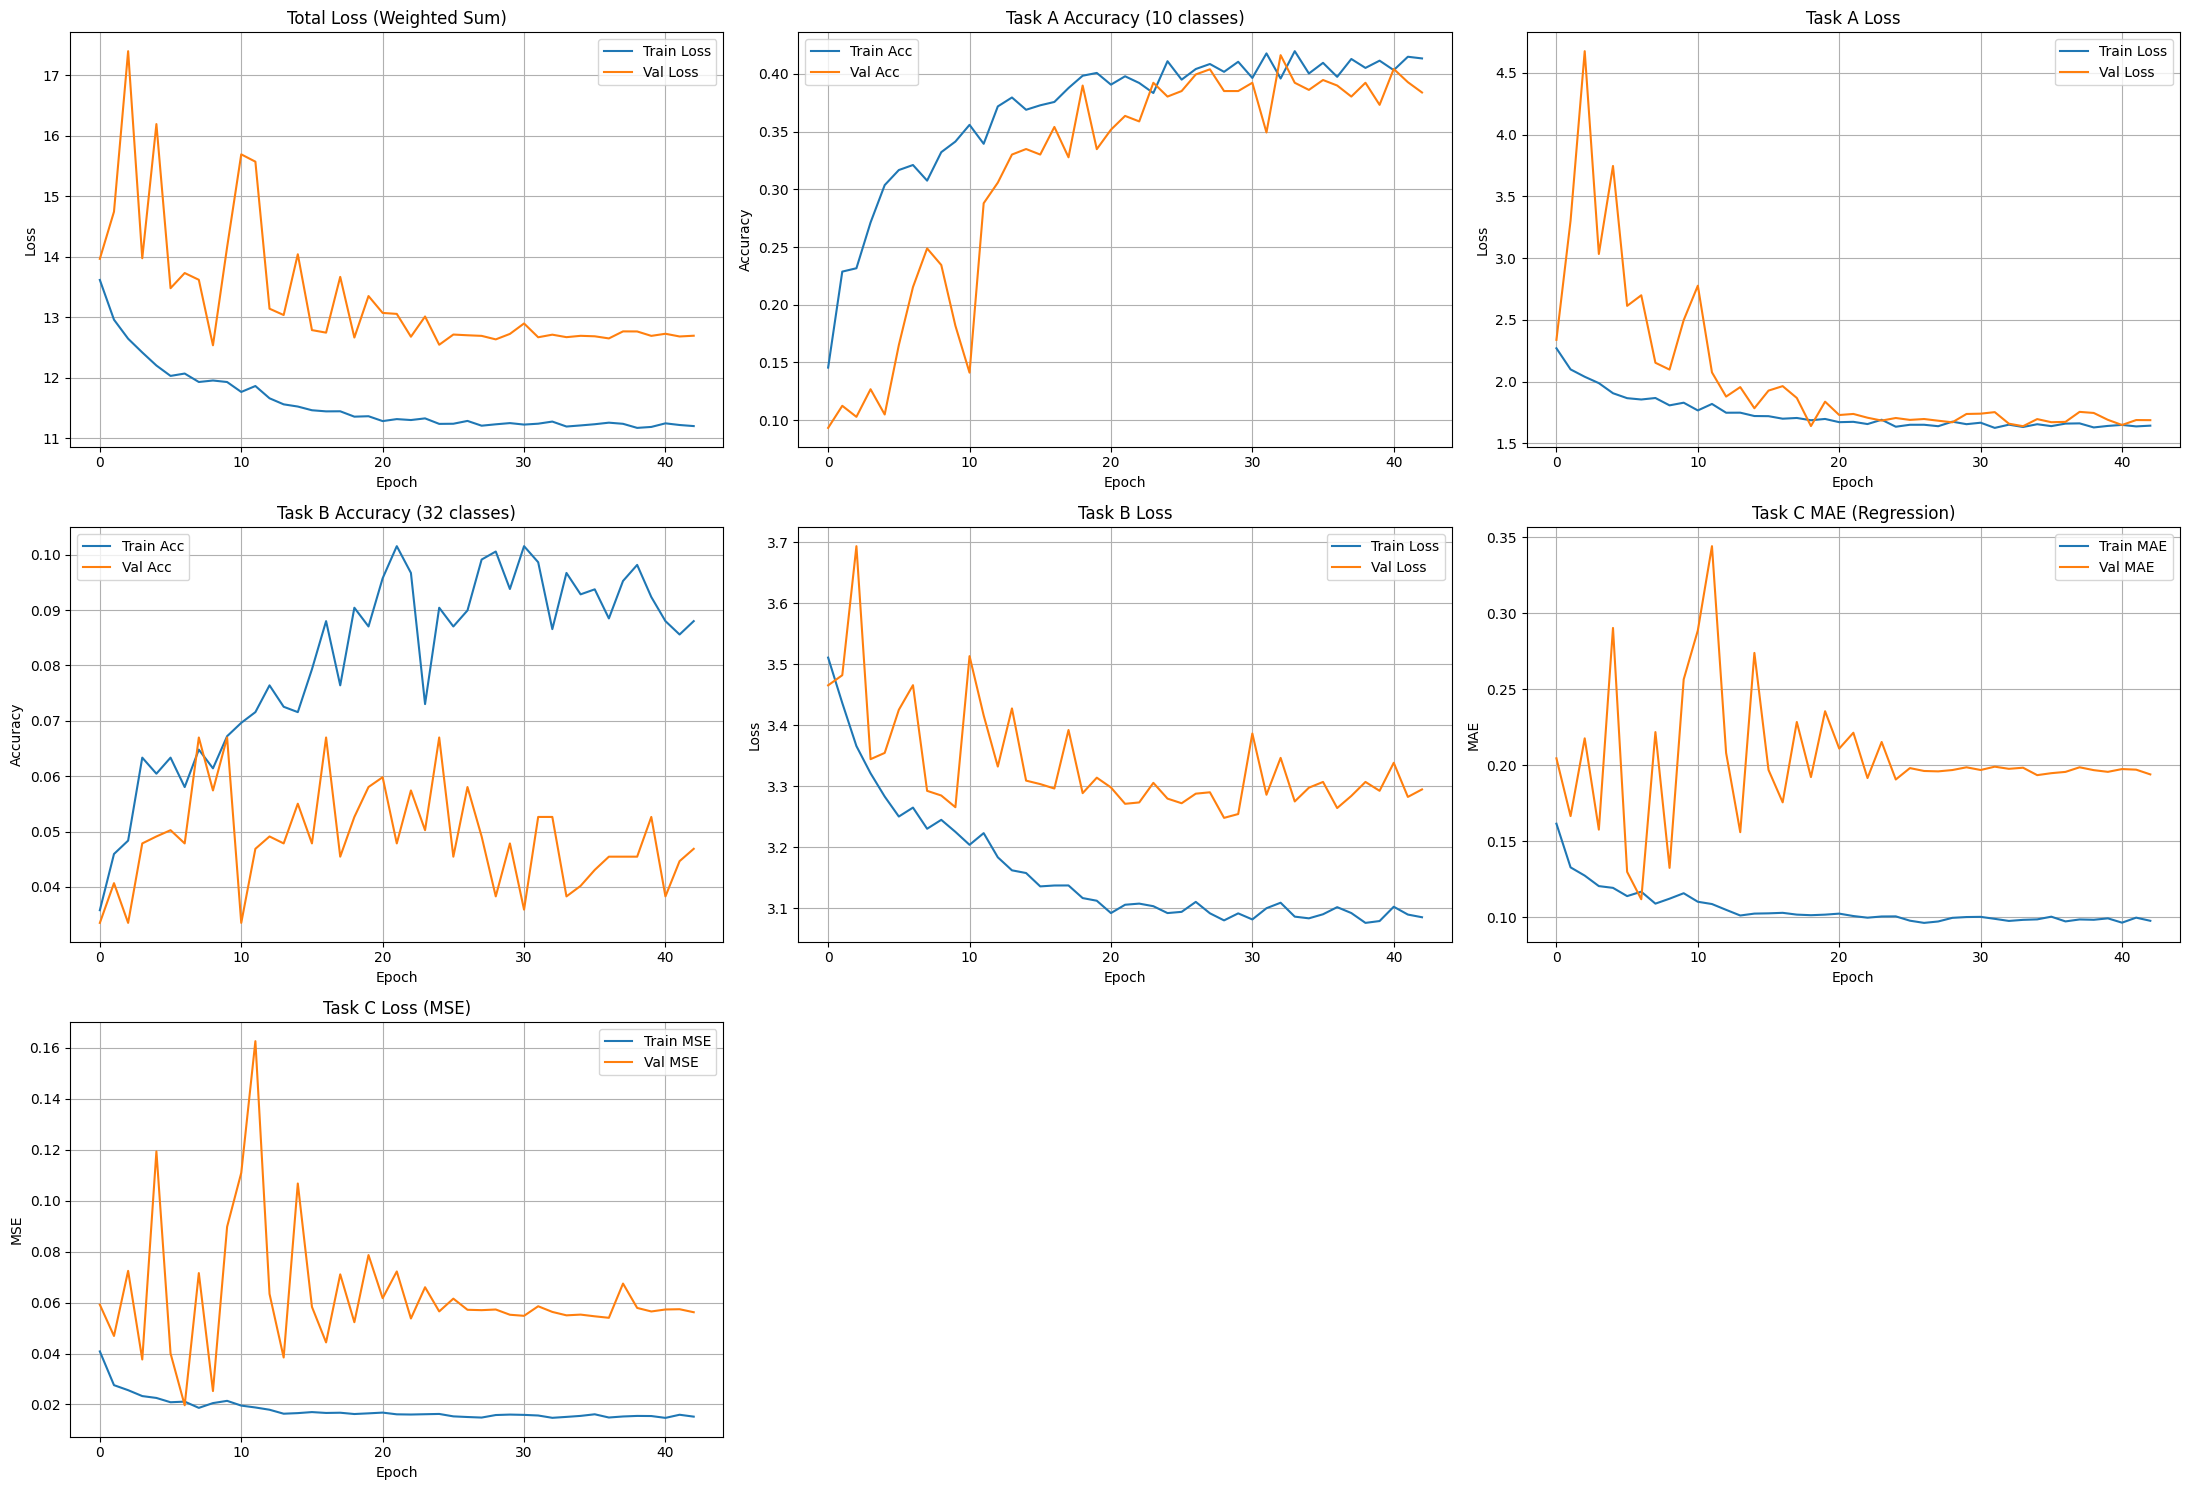

In [ ]:
steps_per_epoch  = len(X_train) // BATCH_SIZE
validation_steps = len(X_val)   // BATCH_SIZE

print("Starting Training (Multi-Task)...")

history = best_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=70,
    callbacks=[metrics_callback, early_stopping, reduce_lr],
    verbose=1
)

print("Training Complete!")

# VISUALIZE TRAINING HISTORY
fig, axes = plt.subplots(3, 3, figsize=(22, 15))

# ========== TOTAL LOSS ==========
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Total Loss (Weighted Sum)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# ========== TASK A ==========
axes[0, 1].plot(history.history['output_A_accuracy'], label='Train Acc')
axes[0, 1].plot(history.history['val_output_A_accuracy'], label='Val Acc')
axes[0, 1].set_title('Task A Accuracy (10 classes)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[0, 2].plot(history.history['output_A_loss'], label='Train Loss')
axes[0, 2].plot(history.history['val_output_A_loss'], label='Val Loss')
axes[0, 2].set_title('Task A Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True)

# ========== TASK B ==========
axes[1, 0].plot(history.history['output_B_accuracy'], label='Train Acc')
axes[1, 0].plot(history.history['val_output_B_accuracy'], label='Val Acc')
axes[1, 0].set_title('Task B Accuracy (32 classes)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history.history['output_B_loss'], label='Train Loss')
axes[1, 1].plot(history.history['val_output_B_loss'], label='Val Loss')
axes[1, 1].set_title('Task B Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

# ========== TASK C ==========
axes[1, 2].plot(history.history['output_C_mae'], label='Train MAE')
axes[1, 2].plot(history.history['val_output_C_mae'], label='Val MAE')
axes[1, 2].set_title('Task C MAE (Regression)')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('MAE')
axes[1, 2].legend()
axes[1, 2].grid(True)

# ========== TASK C LOSS (MSE) ==========
axes[2, 0].plot(history.history['output_C_loss'], label='Train MSE')
axes[2, 0].plot(history.history['val_output_C_loss'], label='Val MSE')
axes[2, 0].set_title('Task C Loss (MSE)')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('MSE')
axes[2, 0].legend()
axes[2, 0].grid(True)

axes[2, 1].axis('off')
axes[2, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
MODEL_FILENAME = 'groupId_model.h5'
best_model.save(MODEL_FILENAME)
print("Model trained and saved.")
best_model.summary()

Model trained and saved.


Model: "MultiTask_Asymmetric_ResNet_Dynamic"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │        640 │ input_image[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_conv1      │ (None, 8, 8, 128) │    147,584 │ max_pooling2d_3[… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_bn1        │ (None, 8, 8, 128) │        512 │ stem_res_conv1[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_relu1      │ (None, 8, 8, 128) │          0 │ stem_res_bn1[0][… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_conv2      │ (None, 8, 8, 128) │    147,584 │ stem_res_relu1[0… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_bn2        │ (None, 8, 8, 128) │        512 │ stem_res_conv2[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_add (Add)  │ (None, 8, 8, 128) │          0 │ stem_res_bn2[0][… │
│                     │                   │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_out        │ (None, 8, 8, 128) │          0 │ stem_res_add[0][… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branchB_res1_conv1  │ (None, 8, 8, 64)  │     73,792 │ stem_res_out[0][

 Total params: 2,526,659 (9.64 MB)

 Trainable params: 841,451 (3.21 MB)

 Non-trainable params: 2,304 (9.00 KB)

 Optimizer params: 1,682,904 (6.42 MB)

## 7 - Model Evaluation

 Running Comprehensive Evaluation on Test Set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 12.9887 - output_A_accuracy: 0.3874 - output_A_loss: 1.7549 - output_B_accuracy: 0.0680 - output_B_loss: 3.2721 - output_C_loss: 0.0720 - output_C_mae: 0.2228

 === Global Metrics ===
loss: 12.9269
compile_metrics: 1.8457
output_A_loss: 3.2698
output_B_loss: 0.0722
output_C_loss: 0.3778

 Generating Predictions...

 TARGET A (10 Classes) - CLASSIFICATION
 Accuracy: 0.3778

Classification Report:

              precision    recall  f1-score   support

           0     0.8571    0.1277    0.2222        47
           1     0.3846    0.2500    0.3030        40
           2     0.1429    0.0408    0.0635        49
           3     0.2941    0.1923    0.2326        52
           4     0.2941    0.3846    0.3333        39
           5     0.3409    0.3750    0.3571        40
           6     0.3803    0.5510    0.4500        49
           7     0.3438    0.4783    0.4000        46
           8    

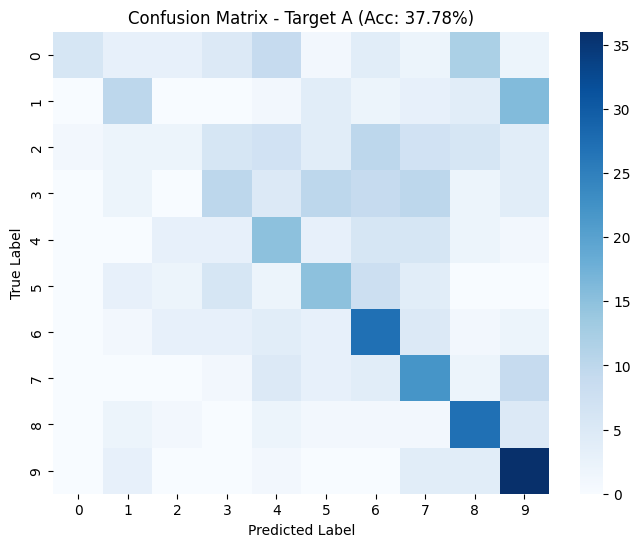


 TARGET B (32 Classes) - CLASSIFICATION
 Top-1 Accuracy: 0.0622
 Top-5 Accuracy: 0.2889 (Model captures semantics well?)

Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        14
           1     0.1200    0.2000    0.1500        15
           2     0.0000    0.0000    0.0000        12
           3     0.0000    0.0000    0.0000        17
           4     0.1538    0.1538    0.1538        13
           5     0.0000    0.0000    0.0000        15
           6     0.0000    0.0000    0.0000        12
           7     0.0000    0.0000    0.0000        14
           8     0.0312    0.0667    0.0426        15
           9     0.0000    0.0000    0.0000        13
          10     0.0000    0.0000    0.0000        13
          11     0.0000    0.0000    0.0000        13
          12     0.0427    0.3333    0.0758        15
          13     0.0400    0.1333    0.0615        15
          14     0.0000    0.0000    0.000

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


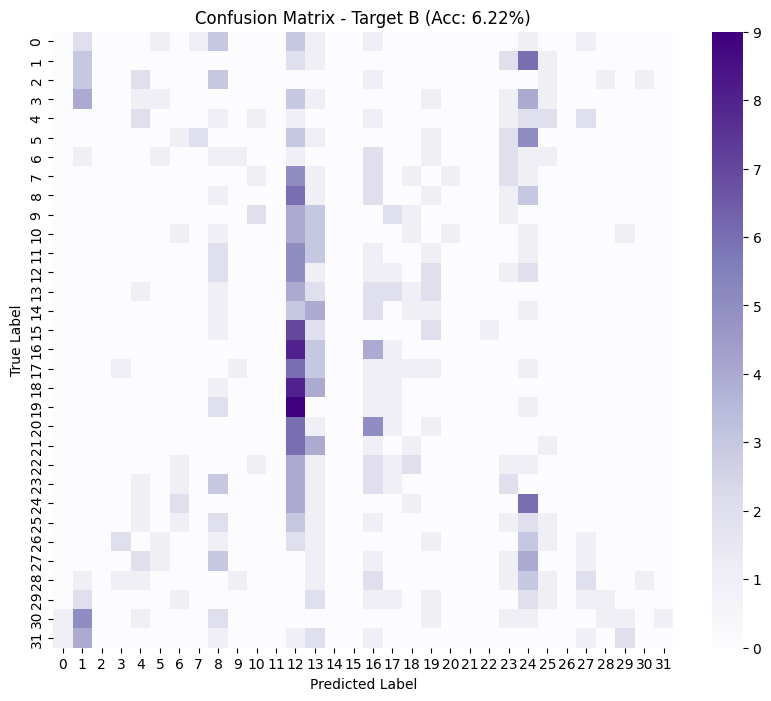


 TARGET C (Regression) - CONTINUOUS VALUE
 Mean Absolute Error (MAE): 0.2162
 Mean Squared Error (MSE):  0.0679
 R-squared Score (R²):      0.1847


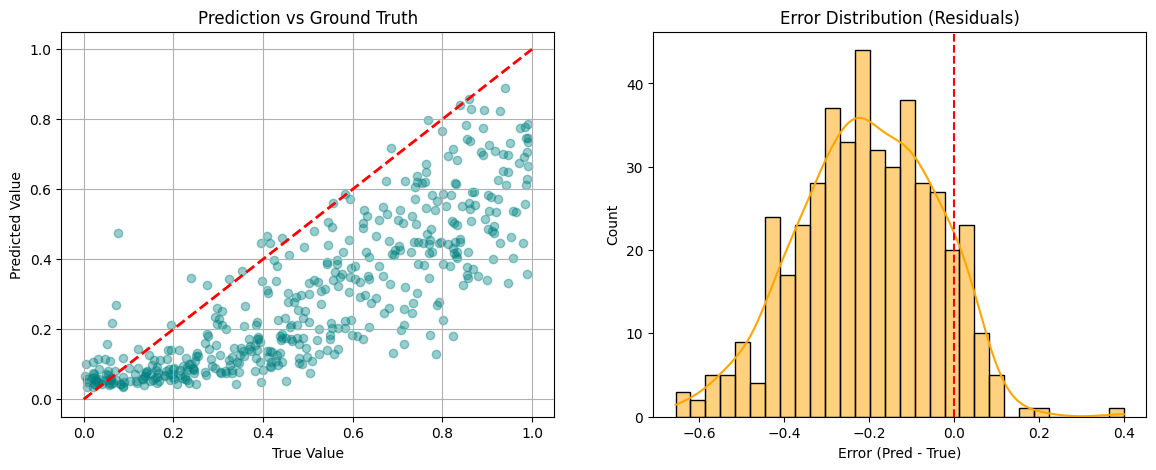


 JOINT PERFORMANCE ANALYSIS
 Exact Match Ratio (All 3 Correct): 0.0000
   (Criteria: Class A correct & Class B correct & Reg C error < 0.05)

 Analyzing 214 Complete Failures (Wrong on A, B, and C):


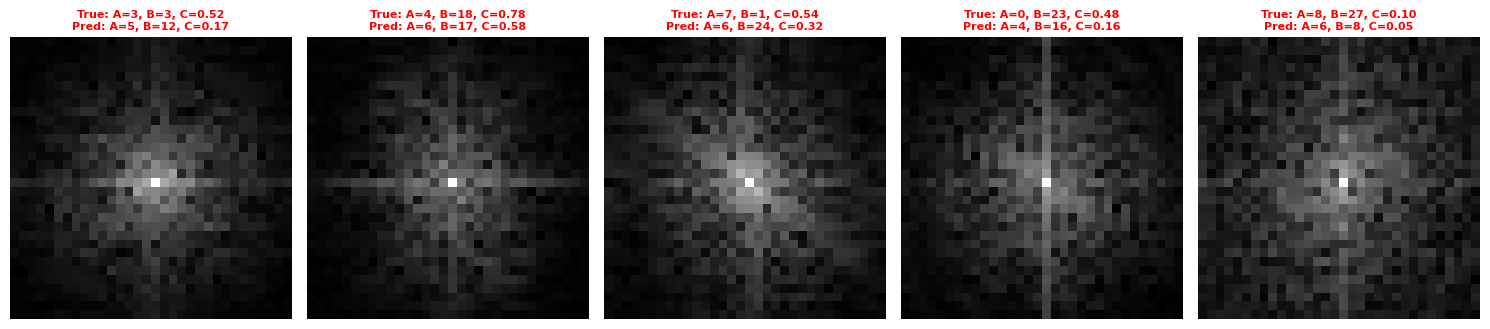

In [ ]:
# 1. OVERALL EVALUATION (LOSS & METRICS)
print(" Running Comprehensive Evaluation on Test Set...")

# Evaluate using Keras built-in function
eval_results = best_model.evaluate(
    X_test,
    {
        'output_A': yA_test,
        'output_B': yB_test,
        'output_C': yC_test_reg
    },
    verbose=1
)

print("\n === Global Metrics ===")
for name, val in zip(best_model.metrics_names, eval_results):
    print(f"{name}: {val:.4f}")

# 2. GENERATE PREDICTIONS
print("\n Generating Predictions...")
pred_A_prob, pred_B_prob, pred_C = best_model.predict(X_test, verbose=0)

# Convert probabilities to class indices
pred_A = np.argmax(pred_A_prob, axis=1)
pred_B = np.argmax(pred_B_prob, axis=1)
pred_C = pred_C.flatten() # Flatten regression output to 1D array

# 3. TARGET A EVALUATION (0-9 Digits)
print("\n" + "="*40)
print(" TARGET A (10 Classes) - CLASSIFICATION")
print("="*40)

acc_A = accuracy_score(yA_test, pred_A)
print(f" Accuracy: {acc_A:.4f}")
print("\nClassification Report:\n")
print(classification_report(yA_test, pred_A, digits=4))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
cm_A = confusion_matrix(yA_test, pred_A)
sns.heatmap(cm_A, annot=False, cmap='Blues', cbar=True)
plt.title(f"Confusion Matrix - Target A (Acc: {acc_A:.2%})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 4. TARGET B EVALUATION (0-31 Classes)
print("\n" + "="*40)
print(" TARGET B (32 Classes) - CLASSIFICATION")
print("="*40)

acc_B = accuracy_score(yB_test, pred_B)
print(f" Top-1 Accuracy: {acc_B:.4f}")

# Calculate Top-5 Accuracy
yB_test_onehot = tf.keras.utils.to_categorical(yB_test, 32)
top5_acc = tf.keras.metrics.top_k_categorical_accuracy(yB_test_onehot, pred_B_prob, k=5)
print(f" Top-5 Accuracy: {np.mean(top5_acc):.4f} (Model captures semantics well?)")

print("\nClassification Report:\n")
print(classification_report(yB_test, pred_B, digits=4))

# Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
cm_B = confusion_matrix(yB_test, pred_B)
sns.heatmap(cm_B, annot=False, cmap='Purples', cbar=True)
plt.title(f"Confusion Matrix - Target B (Acc: {acc_B:.2%})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 5. TARGET C EVALUATION (Regression)
print("\n" + "="*40)
print(" TARGET C (Regression) - CONTINUOUS VALUE")
print("="*40)

mae = mean_absolute_error(yC_test_reg, pred_C)
mse = mean_squared_error(yC_test_reg, pred_C)
r2 = r2_score(yC_test_reg, pred_C)

print(f" Mean Absolute Error (MAE): {mae:.4f}")
print(f" Mean Squared Error (MSE):  {mse:.4f}")
print(f" R-squared Score (R²):      {r2:.4f}")

# Visualization: Scatter Plot & Residual Histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter Plot
axes[0].scatter(yC_test_reg, pred_C, alpha=0.4, color='teal')
axes[0].plot([0, 1], [0, 1], 'r--', lw=2) # Perfect prediction line
axes[0].set_title("Prediction vs Ground Truth")
axes[0].set_xlabel("True Value")
axes[0].set_ylabel("Predicted Value")
axes[0].grid(True)

# Residual Histogram (Check for Bias)
errors = pred_C - yC_test_reg.flatten()
sns.histplot(errors, kde=True, ax=axes[1], color='orange', bins=30)
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_title("Error Distribution (Residuals)")
axes[1].set_xlabel("Error (Pred - True)")
plt.show()

# 6. JOINT ACCURACY & FAILURE ANALYSIS (Multi-task Insight)
print("\n" + "="*40)
print(" JOINT PERFORMANCE ANALYSIS")
print("="*40)

# Define correctness criteria
threshold_C = 0.05
correct_A = (pred_A == yA_test)
correct_B = (pred_B == yB_test)
correct_C = (np.abs(errors) < threshold_C)

# Joint Accuracy: Correct on ALL 3 targets
joint_correct = correct_A & correct_B & correct_C
joint_acc = np.mean(joint_correct)

print(f" Exact Match Ratio (All 3 Correct): {joint_acc:.4f}")
print(f"   (Criteria: Class A correct & Class B correct & Reg C error < {threshold_C})")

# Visualize Worst Failures (Wrong on ALL 3 targets)
failures = np.where(~correct_A & ~correct_B & ~correct_C)[0]

if len(failures) > 0:
    print(f"\n Analyzing {len(failures)} Complete Failures (Wrong on A, B, and C):")
    n_show = min(5, len(failures))
    fig, axes = plt.subplots(1, n_show, figsize=(15, 4))
    if n_show == 1: axes = [axes] # Handle single case

    for i, idx in enumerate(failures[:n_show]):
        ax = axes[i]
        # Reshape & Scale back for display if needed
        img = X_test[idx].squeeze()
        ax.imshow(img, cmap='gray')

        title = (f"True: A={yA_test[idx]}, B={yB_test[idx]}, C={yC_test_reg[idx][0]:.2f}\n"
                 f"Pred: A={pred_A[idx]}, B={pred_B[idx]}, C={pred_C[idx]:.2f}")
        ax.set_title(title, fontsize=8, color='red', fontweight='bold')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("\n Amazing! No samples failed on all 3 targets simultaneously.")